# FOV model
## renew on 2024-4-14

April Fool's Day Celebration Codes

## Setup

In [252]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
import random
az.style.use("arviz-grayscale")

### Load data

Allfishtrial = pd.read_csv('tips.csv')
Allfishtrial.tail()

BRWR_fishid = pd.Categorical(Allfishtrial['fish_id'],
                     categories=['fish3', 'fish7', 'fish9', 'fish10']).codes
BRWR_sessiontype = pd.Categorical(Allfishtrial['session_type'],
                     categories=['Baseliine', 'Rotation', 'Washout', 'ReRotation']).codes


groups_fishid = len(np.unique(BRWR_fishid))


Priors calculation， should get these from raw data

In [253]:
first_day_value = 1
first_trial_value = 1

In [254]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [255]:
# fish_list = [4, 6, 7, 8, 10]
# stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']
# days = {'baseline': 27, 'rotation': 16, 'washout': 10, 'savings': 16, 'washout 2': 10}

# # Initialize an empty list to store the data
# data = []

# stage_Amu = [-1, 5, -1, 5, -1]
# stage_Asd = [5, 5, 5, 5, 5]
# stage_tau = [100,100,100,100,100]
# stage_mu_inf = [0,0,0,0,0.2]


# # Generate data for each fish, epoch, day, and trial
# for f in fish_list:
#     for stage in stage_list:
#         Amu = np.random.normal(loc=stage_Amu[stage], scale=stage_Asd[stage])
#         tau = stage_tau[stage]
#         mu_inf = stage_mu_inf[stage]

#         for day in range(first_day_value, days[stage] + first_day_value):
#             num_trials = np.random.randint(4, 8)  # Randomly choose number of trials per day
#             day_mu = Amu*np.exp(-day/tau) + mu_inf

#             for trial in range(first_trial_value, num_trials + first_trial_value):
#                 yds = np.random.normal(loc=day_mu, scale=30)  # Generate random yds
#                 data.append([f, stage, day, trial, yds])

# # Create a pandas DataFrame
# df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

# num_data = df.shape[0]

In [256]:
# fish_list = [3, 7, 9, 10]
# stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']
# days = {'baseline': 20, 'rotation': 15, 'washout': 10, 'savings': 15, 'washout 2': 10}

# # Initialize an empty list to store the data
# data = []

# # Define parameters for each stage
# stage_params = {
#     'baseline': {'Amu': -1, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'rotation': {'Amu': 5, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'washout': {'Amu': -1, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'savings': {'Amu': 5, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'washout 2': {'Amu': -1, 'Asd': 3, 'tau': 1, 'mu_inf': 0}
# }

# # Generate data for each fish, epoch, day, and trial
# for f in fish_list:
#     for stage in stage_list:
#         Amu = stage_params[stage]['Amu']
#         Asd = stage_params[stage]['Asd']
#         tau = stage_params[stage]['tau']
#         mu_inf = stage_params[stage]['mu_inf']

#         for day in range(1, days[stage] + 1):
#             num_trials = 6 # Randomly choose number of trials per day
#             day_mu = Amu * np.exp(-day / tau) + mu_inf

#             for trial in range(1, num_trials + 1):
#                 yds = np.random.normal(loc=day_mu, scale=30)  # Generate random yds
#                 data.append([f, stage, day, trial, yds])

# # Create a pandas DataFrame
# df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

# num_data = df.shape[0]
# print("Number of data points:", num_data)


In [257]:
stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']


In [258]:


sim = {
#------------------------------------------------------------------------------------------
#    the parameter of μ_μd
    # The amount of learning across fish (for each stage)   For the normal distribution
    "μ_Aμμ": [-1, 5, -1, 5, -1],
    "σ_Aμμ": [5, 5, 5, 5, 5],
 
    # Time constant of learning across fish (for each stage)    For the the gamma distrition 
    "m_τμμ": [4, 4, 4, 4, 4],
    "σ_τμμ": [1.5, 1.5, 1.5, 1.5, 1.5],

    # End point of learning across fish (for each stage)    For the normal ditribution
    "μ_μμ_inf": [0, 0, 0, 0, 0],
    "σ_μμ_inf": [1, 1, 1, 1, 1],

#------------------------------------------------------------------------------------------
#   the parameter of σ_μd
    # Change in std of days around mean value across fish (for each stage) for the half-normal distribution
    "σ_Aσμ": [1, 1, 1, 1, 1],
     
    # Time std of learning across fish (for each stage)    For the the gamma distrition 
    "m_τσμ": [4, 4, 4, 4, 4],
    "σ_τσμ": [1.5, 1.5, 1.5, 1.5, 1.5],

    # Final std of days around mean value across fish (for each stage) for the half-normal distribution
    "σ_σμ_inf": [0.5, 0.5, 0.5, 0.5, 0.5],

#-------------------------------------------------------------------------------------------
#   the parameter of m_σd
    
    # Mode of change in std of trials around day across fish (for each stage) For the the gamma distrition 
    "m_Amσ": [20, 10, 10, 10, 5],
    "σ_Amσ": [10, 10, 10, 10, 10],

    # Time constant of variance reduction across fish (for each stage) For the the gamma distrition 
    "m_τμσ": [3, 3, 3, 3, 3],
    "σ_τμσ": [1.5, 1.5, 1.5, 1.5, 1.5],
    
    # Mode of final std of trials around day across fish (for each stage) For the the gamma distrition 
    "m_mσ_inf": [5, 5, 5, 5, 5],
    "σ_mσ_inf": [3, 3, 3, 3, 3],
#-----------------------------------------------------------------------------------------------
#   the parameter of σ_σd
    # Std of final std of trials around day across fish (for each stage) for the half-normal distribution
    "σ_Aσσ": [1, 1, 1, 1, 1],


    # Time constant of variance reduction across fish (for each stage) For the the gamma distrition 
    "m_τσσ": [3, 3, 3, 3, 3],
    "σ_τσσ": [1.5, 1.5, 1.5, 1.5, 1.5],
    
    # Mode of final std of trials around day across fish (for each stage) for the half-normal distribution
    "σ_σσ_inf": [3, 3, 3, 3, 3],  





}

sim_df = pd.DataFrame(index=stage_list, columns=sim.keys())
for k,v in sim.items():
    sim_df[k] = v

In [259]:
sim_df

,μ_Aμμ,σ_Aμμ,m_τμμ,σ_τμμ,μ_μμ_inf,σ_μμ_inf,σ_Aσμ,m_τσμ,σ_τσμ,σ_σμ_inf,m_Amσ,σ_Amσ,m_τμσ,σ_τμσ,m_mσ_inf,σ_mσ_inf,σ_Aσσ,m_τσσ,σ_τσσ,σ_σσ_inf
baseline,-1,5,4,1.5,0,1,1,4,1.5,0.5,20,10,3,1.5,5,3,1,3,1.5,3
rotation,5,5,4,1.5,0,1,1,4,1.5,0.5,10,10,3,1.5,5,3,1,3,1.5,3
washout,-1,5,4,1.5,0,1,1,4,1.5,0.5,10,10,3,1.5,5,3,1,3,1.5,3
savings,5,5,4,1.5,0,1,1,4,1.5,0.5,10,10,3,1.5,5,3,1,3,1.5,3
washout 2,-1,5,4,1.5,0,1,1,4,1.5,0.5,5,10,3,1.5,5,3,1,3,1.5,3


In [260]:
fish_list = [3, 7, 9, 10]
days = {'baseline': 25, 'rotation': 15, 'washout': 10, 'savings': 15, 'washout 2': 10}

# Initialize an empty list to store the data
data = []

# Generate data for each fish, epoch, day, and trial
for f in fish_list:
    for stage in stage_list:
        sim_s = sim_df.loc[stage]
        
        # Parameters for mean of days
        A_mumu = np.random.normal(loc=sim_s["μ_Aμμ"], scale=sim_s["σ_Aμμ"])
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τμμ"], sim_s["σ_τμμ"])
        tau_mumu = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        mumu_inf = np.random.normal(loc=sim_s["μ_μμ_inf"], scale=sim_s["σ_μμ_inf"])        
        
        # Parameters for std of days
        A_sdmu = np.abs(np.random.normal(loc=0, scale=sim_s["σ_Aσμ"]))
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τσμ"], sim_s["σ_τσμ"])
        tau_sdmu = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        σ_sdmu_inf = np.abs(np.random.normal(loc=0, scale=sim_s["σ_σμ_inf"]))

        
        # Parameters for std of trials within day
        # m_σd
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_Amσ"], sim_s["σ_Amσ"])
        A_musd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τμσ"], sim_s["σ_τμσ"])
        tau_musd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_mσ_inf"], sim_s["σ_mσ_inf"])
        mu_sd_inf = np.random.gamma(shape=tau_sh, scale=1/tau_ra) 


        #σ_σd
        A_sdsd = np.abs(np.random.normal(loc=0, scale=sim_s["σ_Aσσ"])) 
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τσσ"], sim_s["σ_τσσ"])     
        tau_sdsd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        σ_sdsd = np.abs(np.random.normal(loc=0, scale=sim_s["σ_σσ_inf"]))         
        





        for day in range(first_day_value, days[stage] + first_day_value):
            num_trials = 6  # Randomly choose number of trials per day
            day_mu_mu = A_mumu*np.exp(-day/tau_mumu) + mumu_inf
            day_mu_sd = A_sdmu*np.exp(-day/tau_sdmu) + σ_sdmu_inf
            day_mu = np.random.normal(loc=day_mu_mu, scale=day_mu_sd)

            day_sd_mu = A_musd*np.exp(-day/tau_musd) + mu_sd_inf
            day_sd_sd = A_sdsd*np.exp(-day/tau_sdsd) + σ_sdsd

            tau_sh, tau_ra = gamma_shra_from_modesd(day_sd_mu, day_sd_sd)  
            day_sd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
                 


            for trial in range(first_trial_value, num_trials + first_trial_value):
                yds = np.random.normal(loc=day_mu, scale=day_sd)  # Generate random yds
                data.append([f, stage, day, trial, yds])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

num_data = df.shape[0]

In [261]:
df

,fish,stage,day,trial,yds
0,3,baseline,1,1,-8.128095
1,3,baseline,1,2,20.504103
2,3,baseline,1,3,-80.030709
3,3,baseline,1,4,-24.860620
4,3,baseline,1,5,-7.431994
...,...,...,...,...,...
1795,10,washout 2,10,2,-1.495075
1796,10,washout 2,10,3,-0.986938
1797,10,washout 2,10,4,-4.872318
1798,10,washout 2,10,5,-3.751036


## Define model

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [262]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['yds_first'] - merged_data['yds_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()

# Priors for τ_μμ
merged_data['halfway_yds'] = (merged_data['yds_first'] + merged_data['yds_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_yds']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['yds'] < df_avg['halfway_yds']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()
σ_τμ = df_avg_below_halfway['day'].std()

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['yds'].mean()
σ_μμ_inf = mean_last_day['yds'].std()


In [263]:
print(f'{μ_Aμμ=}')
print(f'{σ_Aμμ=}')

print(f'{mode_τμ=}')
print(f'{σ_τμ=}')

print(f'{μ_μμ_inf=}')
print(f'{σ_μμ_inf=}')


μ_Aμμ=-0.8325582217834148
σ_Aμμ=6.634579816474508
mode_τμ=2.05
σ_τμ=2.0641042405337657
μ_μμ_inf=0.3608652260737384
σ_μμ_inf=3.94786866903136


#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [264]:
# Priors for Aσμ
σ_Aσμ = merged_data['difference'].std()

# Priors for σ_μ∞
σ_σμ_inf = mean_last_day['yds'].std()


In [265]:
print(f'{σ_Aσμ=}')

# print(f'{μ_τμ=}')
print(f'{σ_τμ=}')

print(f'{σ_σμ_inf=}')

σ_Aσμ=6.634579816474508
σ_τμ=2.0641042405337657
σ_σμ_inf=3.94786866903136


#### μ_σ hyper priors
The central value for standard deviation of trials around the mean behavior of a fish on a given day.

In [266]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'std'}).reset_index()
df_std.rename(columns={'yds': 'std_yds'}, inplace=True)

std_first_day = df_std[df_std['day'] == first_day_value]
last_day_indices = df_std.groupby(['fish', 'stage'])['day'].idxmax()
std_last_day = df_std.loc[last_day_indices]

merged_std = pd.merge(std_first_day, std_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_std['std_diff'] = merged_std['std_yds_first'] - merged_std['std_yds_last']


σ_Aμσ = np.abs(merged_std['std_diff'].mean())/5

# Priors for τ_μσ
merged_std['halfway_std'] = (merged_std['std_yds_first'] + merged_std['std_yds_last']) / 2
df_std = pd.merge(df_std, merged_std[['fish', 'stage', 'halfway_std']], on=['fish', 'stage'])
std_less_than_halfway = df_std[df_std['std_yds'] < df_std['halfway_std']].groupby(['fish', 'stage']).agg({'day': 'min'}).reset_index()

mode_τσ = std_less_than_halfway['day'].mean()
σ_τσ = std_less_than_halfway['day'].std()

sh_τσ,ra_τσ = gamma_shra_from_modesd(mode_τσ, σ_τσ)

# Priors for μ_σ∞
σ_μσ_inf = std_last_day['std_yds'].mean()/5

In [267]:
print(f'{σ_Aμσ=}')

print(f'{mode_τσ=}')
print(f'{σ_τσ=}')

print(f'{σ_μσ_inf=}')

σ_Aμσ=1.752603468252934
mode_τσ=3.0
σ_τσ=1.2977713690461004
σ_μσ_inf=1.1274018811215873


#### σ_σ hyper priors
The standard deviation across fish for the standard deviation across trials on a given day: how much does the varaibility of the trials vary across fish.

In [268]:
# Priors for Aσσ
σ_Aσσ = merged_std['std_diff'].std()/10

# Priors for σ_μ∞
σ_σσ_inf = std_last_day['std_yds'].std()/10

In [269]:
print(f'{σ_Aσσ=}')

print(f'{σ_σσ_inf=}')

σ_Aσσ=0.9443773752083165
σ_σσ_inf=0.32988477945791955


#### Prior for student's t distribution degrees of freedom

In [270]:
μ_ν = 100

### PyMC model code

#### Make codings for fish and stage

In [271]:
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}

# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value

#### Model code

In [286]:
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

with pm.Model(coords=coords) as m_yds:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ
    A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Normal('μ_μ_inf', mu=μ_μμ_inf, sigma=σ_μμ_inf, dims=('fish', 'stages'))

    A_σμ = pm.HalfNormal('A_σμ', sigma=σ_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.HalfNormal('σ_μ_inf', sigma=σ_σμ_inf, dims=('fish', 'stages'))

    A_μσ = pm.HalfNormal('A_μσ', sigma=σ_Aμσ, dims=('fish', 'stages'))
    τ_σ = pm.Gamma('τ_σ', alpha=sh_τσ, beta=ra_τσ, dims=('fish', 'stages'))
    μ_σ_inf = pm.HalfNormal('μ_σ_inf', sigma=σ_μσ_inf, dims=('fish', 'stages'))

    A_σσ = pm.HalfNormal('A_σσ', sigma=σ_Aσσ, dims=('fish', 'stages'))
    σ_σ_inf = pm.HalfNormal('σ_σ_inf', sigma=σ_σσ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ and σ
    μ_μ = pm.Deterministic('μ_μ', A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_], dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')
    mode_σ = pm.Deterministic('μ_σ', A_μσ[fish_,stage_]*pm.math.exp(-day_ / τ_σ[fish_,stage_]) + μ_σ_inf[fish_,stage_], dims='data')
    σ_σ = pm.Deterministic('σ_σ', A_σσ[fish_,stage_]*pm.math.exp(-day_ / τ_σ[fish_,stage_]) + σ_σ_inf[fish_,stage_], dims='data')
    sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

    ### level 2: Priors for the likelihood
    μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')
    ν = pm.Exponential('ν', lam=1/μ_ν)
    
    ### data likelihood level 1
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
    y = pm.Normal('y', mu=μ, sigma=σ, observed=df['yds'], dims='data')



In [273]:
σ_Aμσ

1.752603468252934

# Priors

## Sample prior predictive

In [274]:
import pytensor as pyt
pyt.config.exception_verbosity = 'low'


In [287]:
id_yds = pm.sample_prior_predictive(samples=200, model=m_yds)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data

id_yds

Sampling: [A_μμ, A_μσ, A_σμ, A_σσ, y, μ, μ_μ_inf, μ_σ_inf, ν, σ, σ_μ_inf, σ_σ_inf, τ_μ, τ_σ]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## Plot priors

### Priors for the hyperparameters

In [276]:
start_day = -24
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [277]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 10)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")

    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\Opher\AppData\Local\Temp\ipykernel_29236\1026211821.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


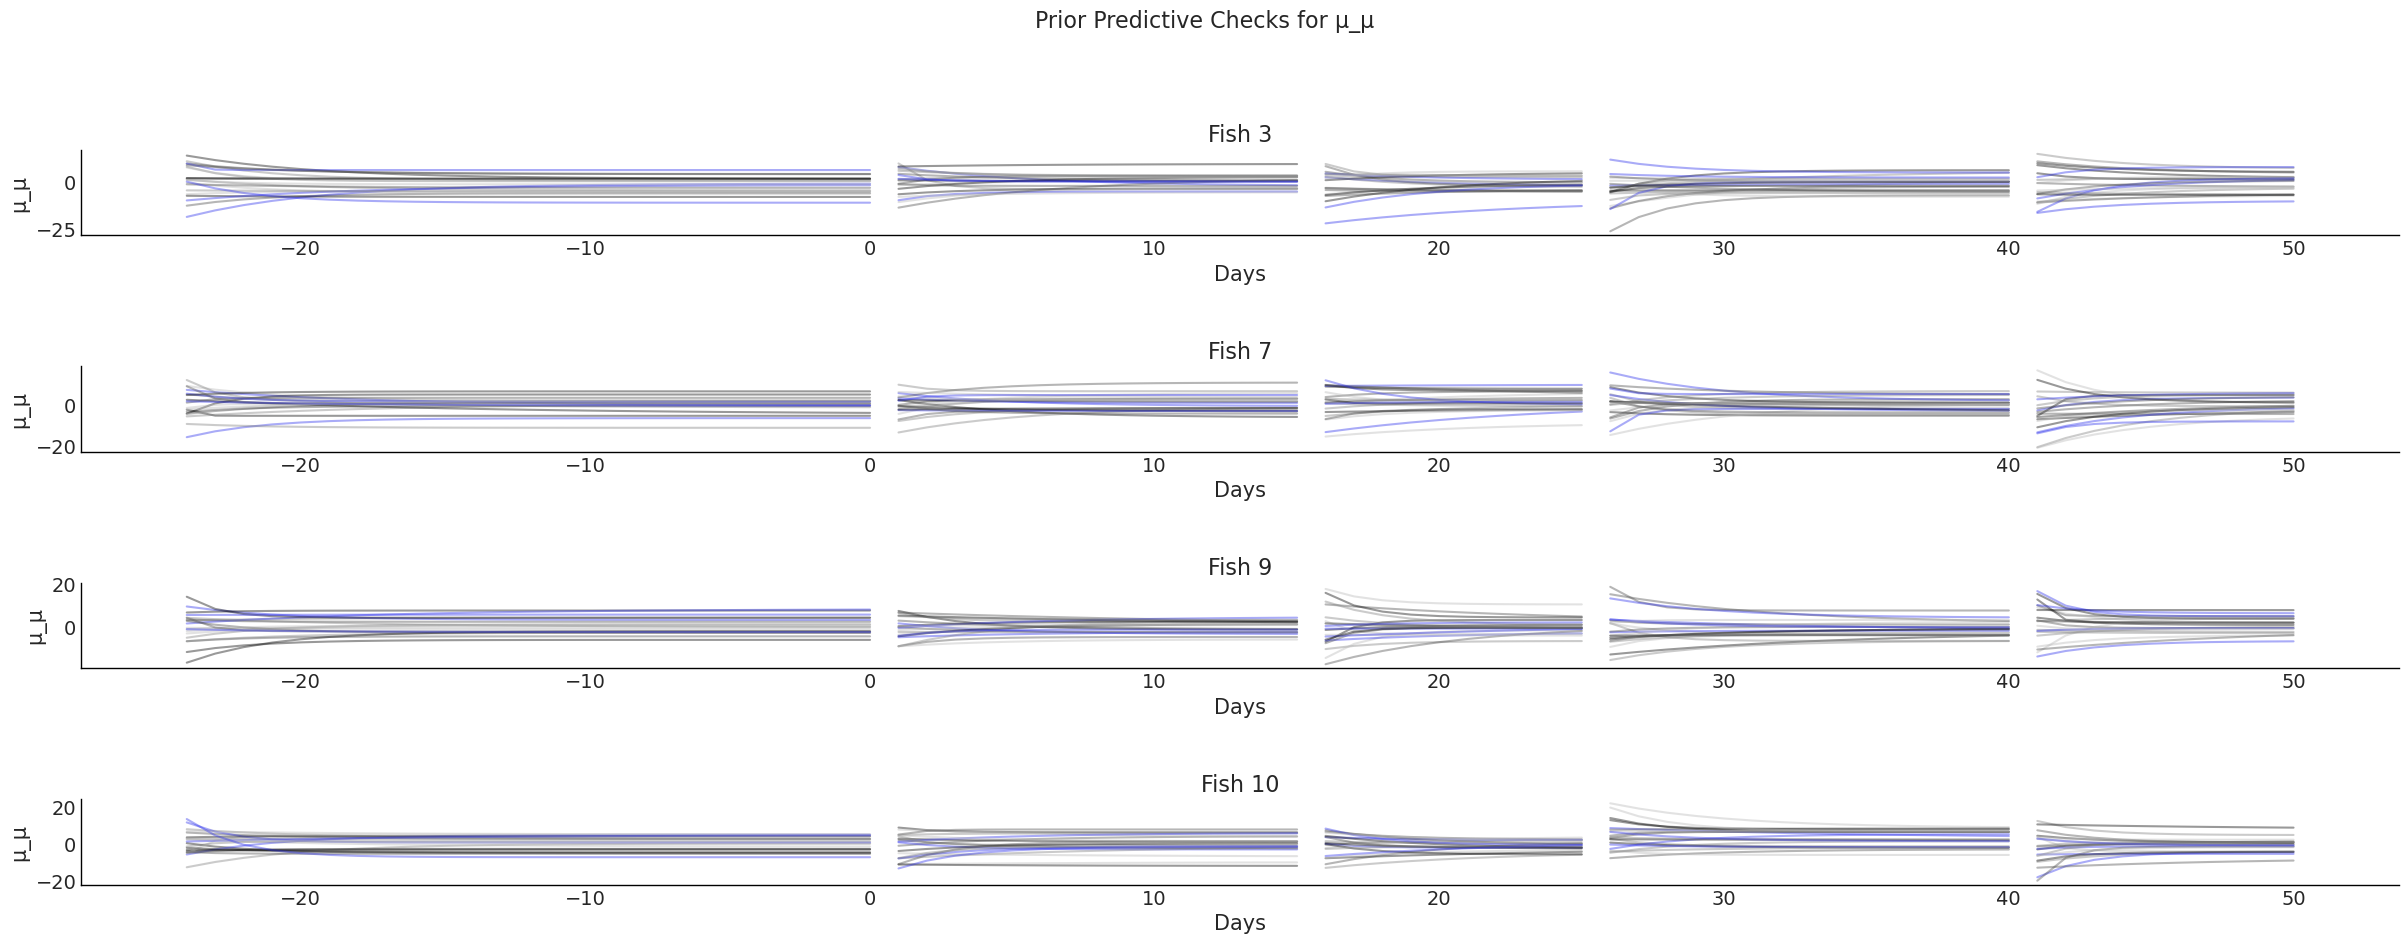

In [278]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")


C:\Users\Opher\AppData\Local\Temp\ipykernel_29236\1026211821.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


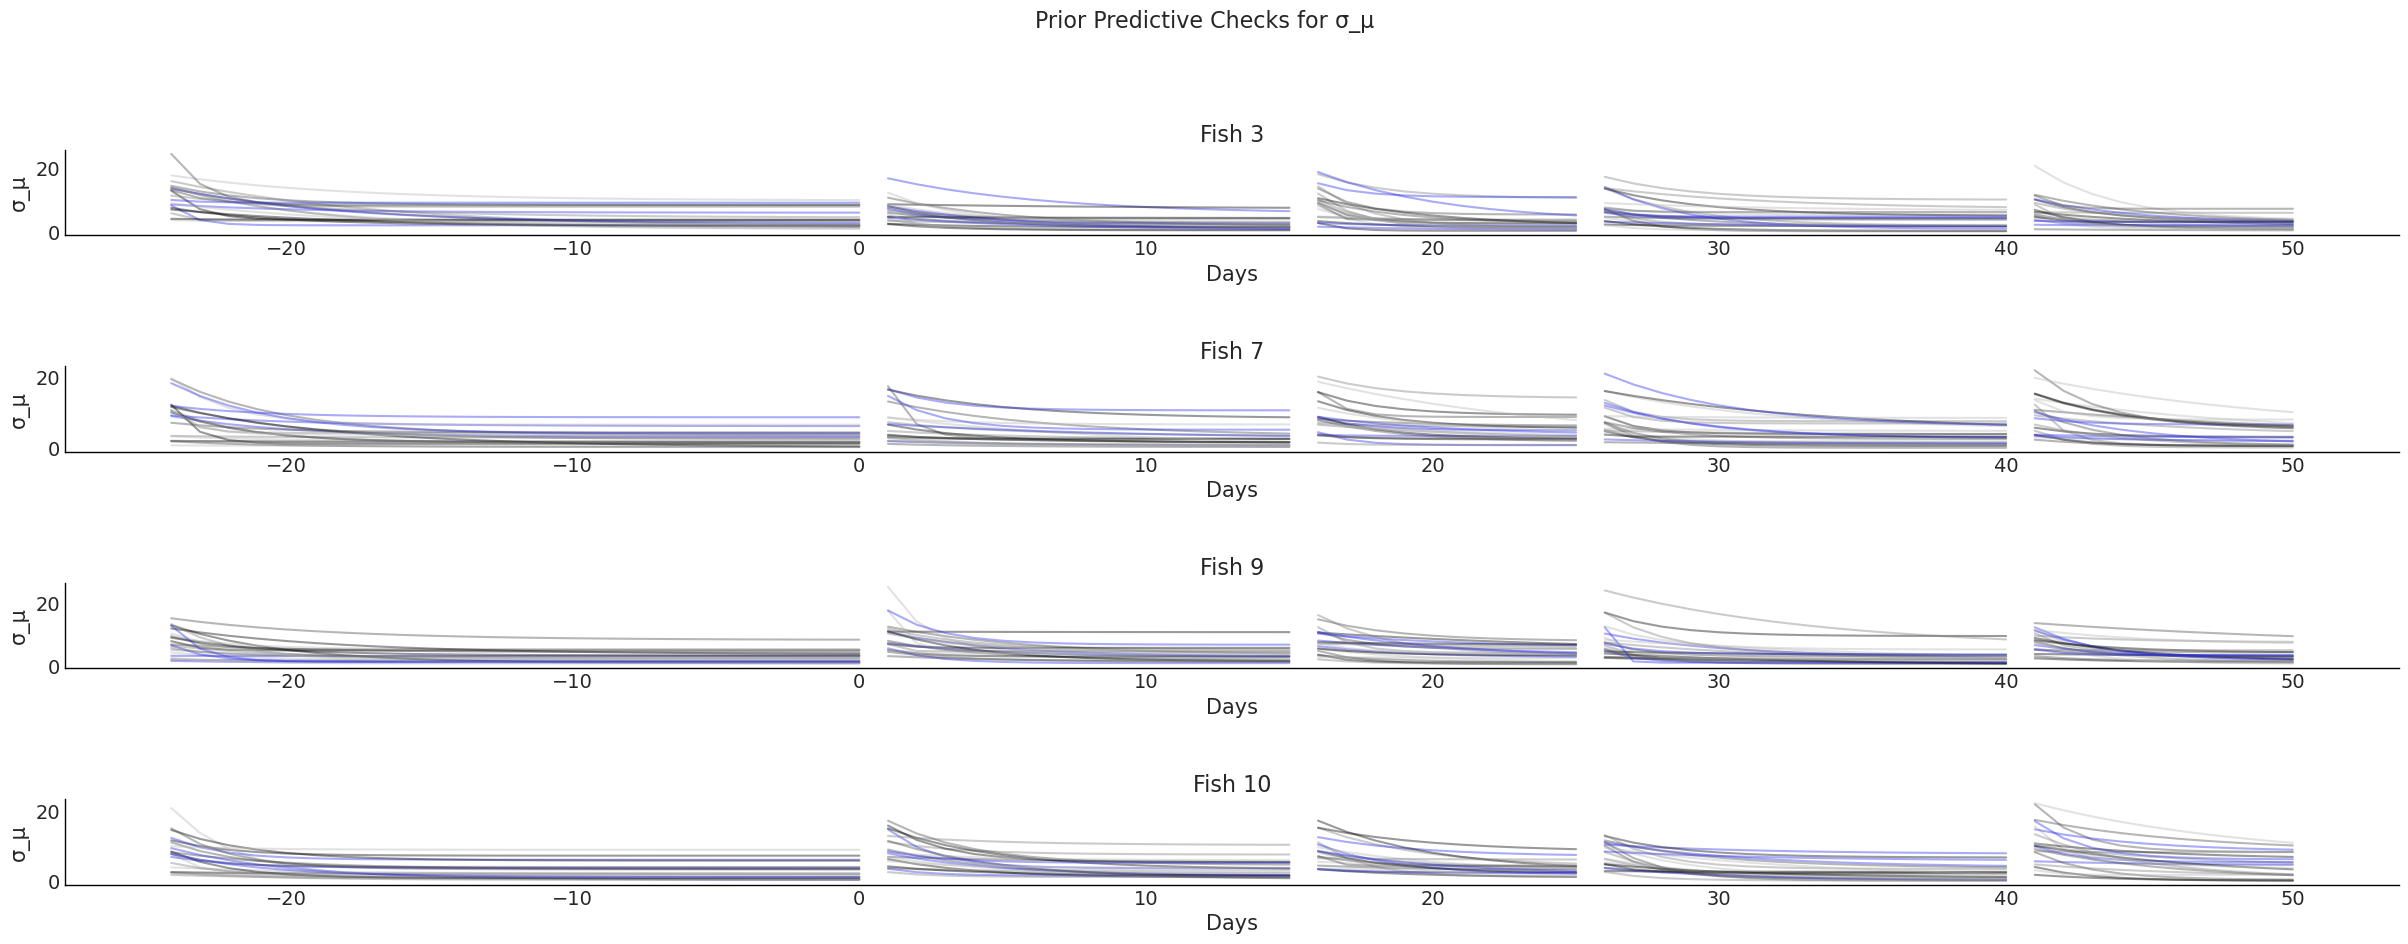

In [279]:
plot_hyperparameter_time_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")


C:\Users\Opher\AppData\Local\Temp\ipykernel_29236\1026211821.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


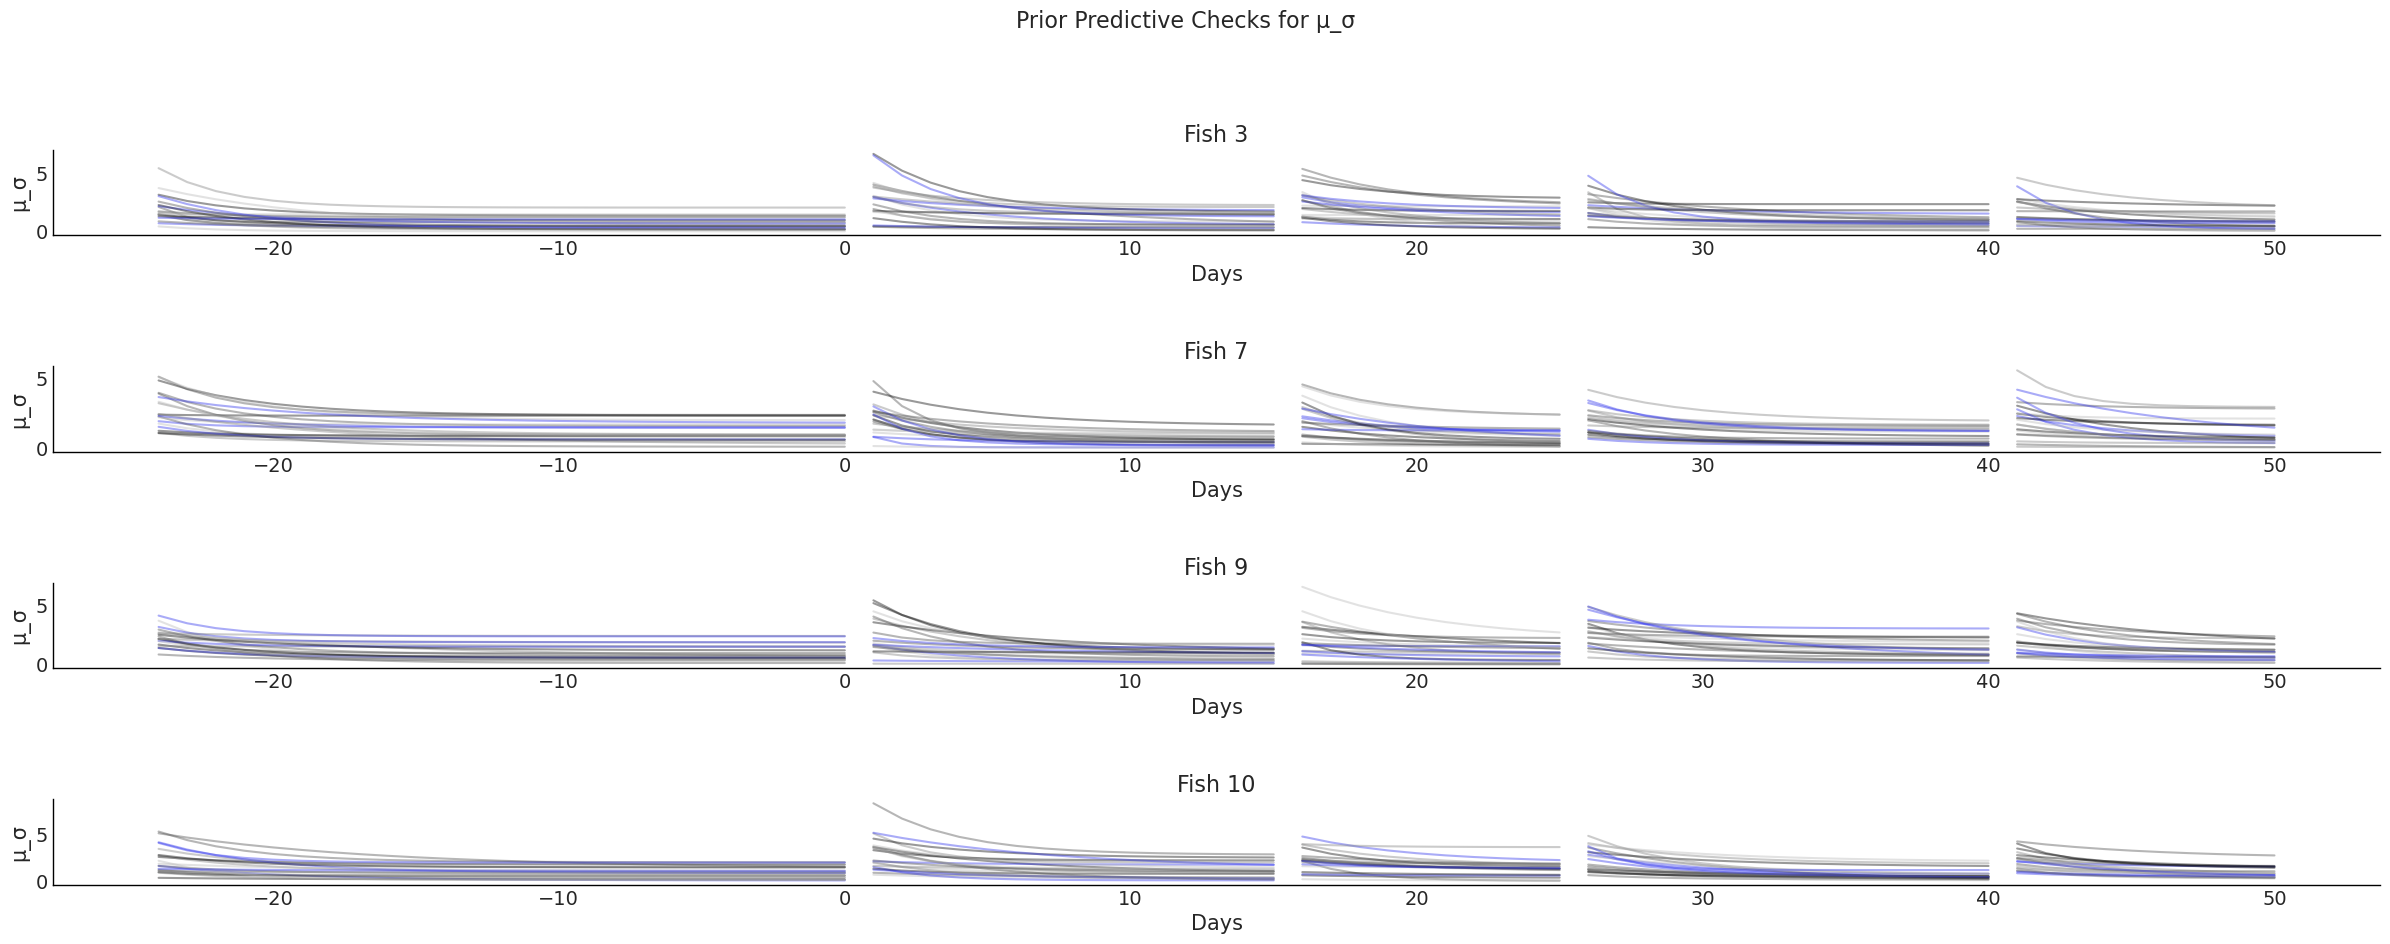

In [280]:
plot_hyperparameter_time_course("A_μσ", "τ_σ", "μ_σ_inf", "μ_σ")

C:\Users\Opher\AppData\Local\Temp\ipykernel_29236\1026211821.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


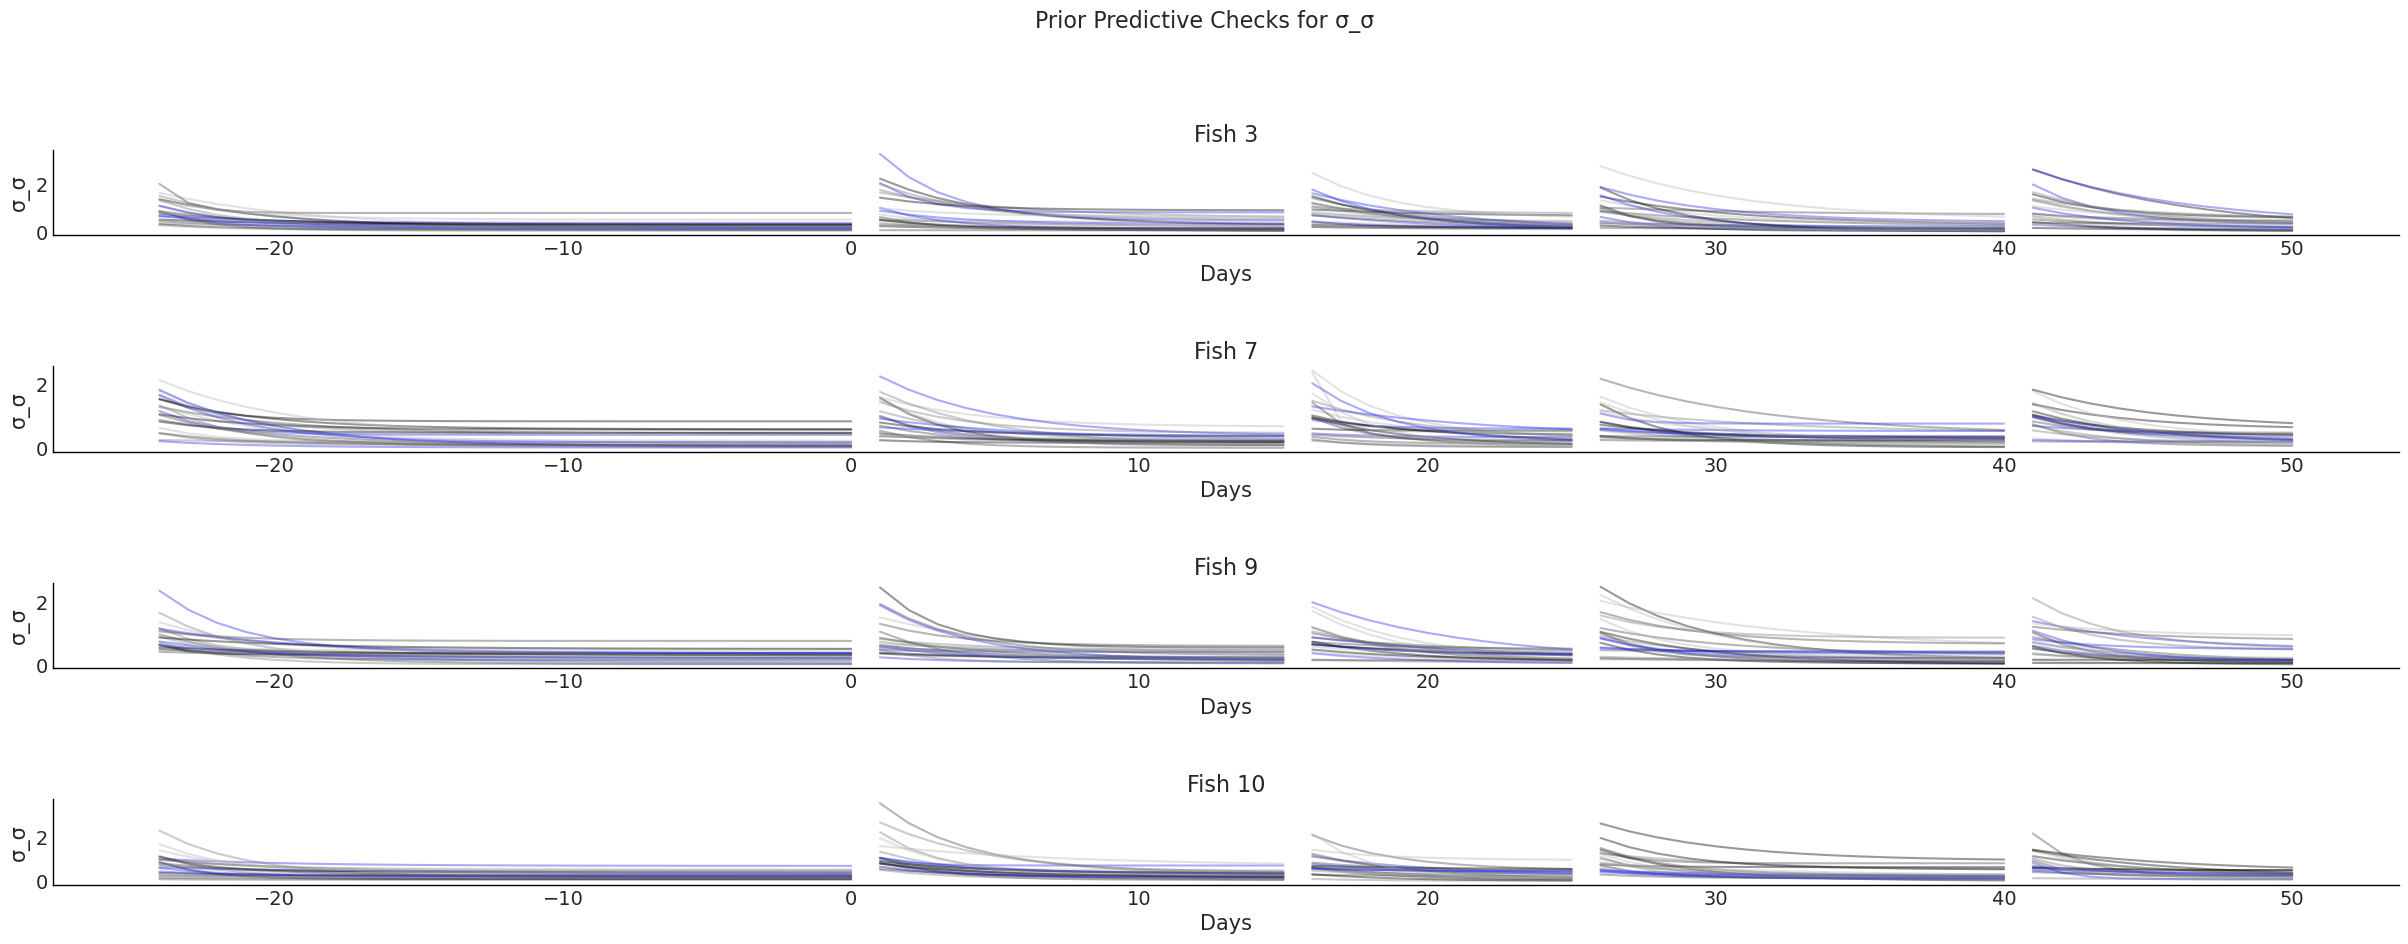

In [281]:
plot_hyperparameter_time_course("A_σσ", "τ_σ", "σ_σ_inf", "σ_σ")

### Plot prior parameters

In [282]:
index_stage_map = {v:k for k,v in stage_index_map.items()}
day_range_ = xr.ones_like(cd.day_)
for i in day_range_['data']:
    stage_id = index_stage_map[cd.stage_[i].item()]
    day_range_[i] = day_ranges[stage_id][cd.day_[i].item()]

In [290]:
def plot_data_time_course_across_fish(day, data, data_name):
    plot_ds = xr.Dataset(data_vars={'day': day, 'data': data})

    fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

    plot_df = plot_ds.to_dataframe().reset_index()
    plot_df['day'] = plot_df['day'].astype(int)
    sns.violinplot(data=plot_df, x='day', y='data', ax=ax, inner='quartile')
    ax.set_title(f'{data_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{data_name}')

Text(0, 0.5, 'mu_yds')

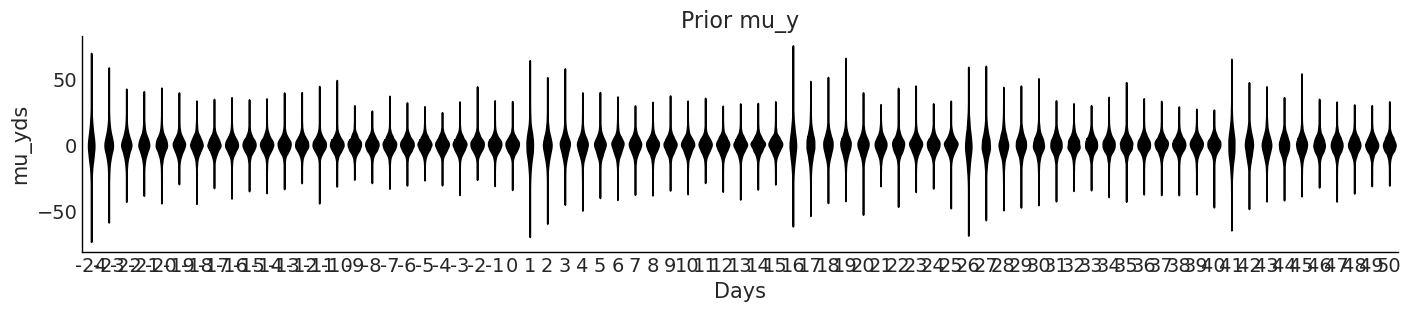

In [292]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'mu_y': prior['μ']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='mu_y', ax=ax, inner='quartile')
ax.set_title(f'Prior mu_y')
ax.set_xlabel('Days')
ax.set_ylabel('mu_yds')

Text(0, 0.5, 'sigma_yds')

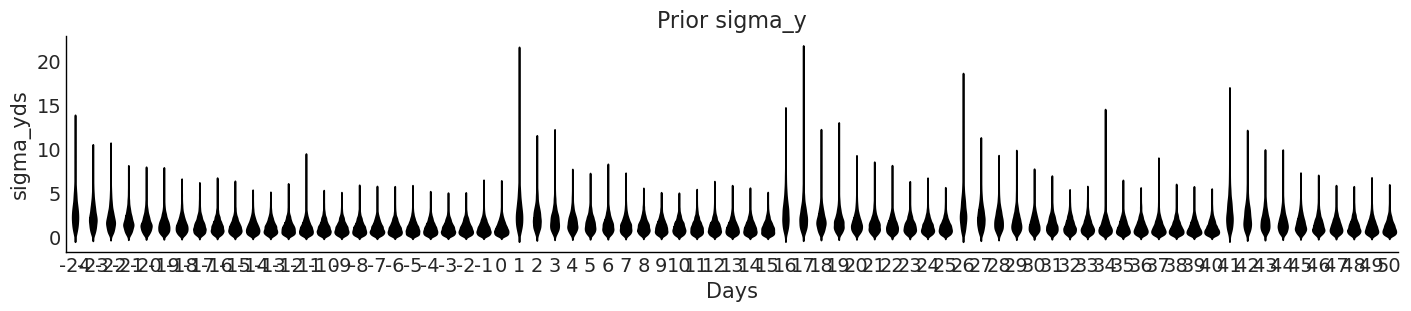

In [293]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'sigma_y': prior['σ']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='sigma_y', ax=ax, inner='quartile')
ax.set_title(f'Prior sigma_y')
ax.set_xlabel('Days')
ax.set_ylabel('sigma_yds')

Text(0, 0.5, 'Yds')

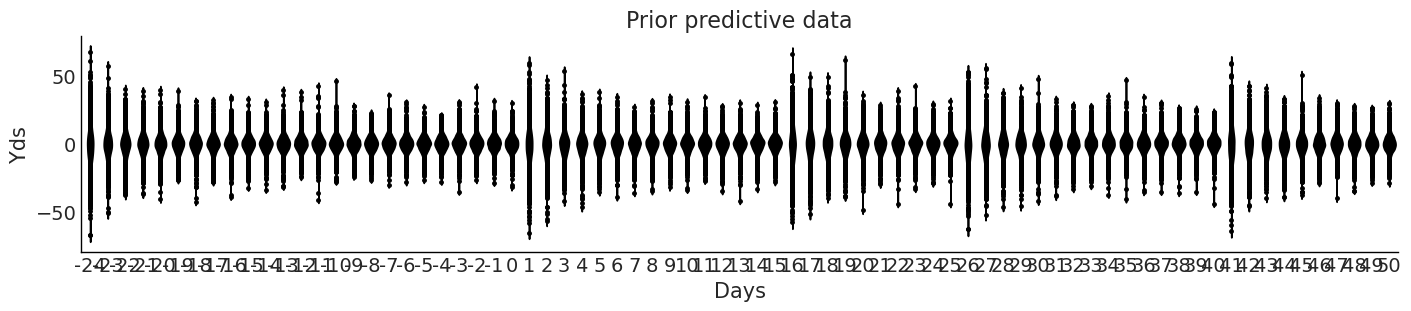

In [294]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'y_pp': pp['y']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='y_pp', ax=ax, inner='point')
ax.set_title(f'Prior predictive data')
ax.set_xlabel('Days')
ax.set_ylabel('Yds')

Try sample

In [295]:
with m_yds:
    id_yds.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_μμ, τ_μ, μ_μ_inf, A_σμ, σ_μ_inf, A_μσ, τ_σ, μ_σ_inf, A_σσ, σ_σ_inf, μ, σ, ν]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1902 seconds.
There were 2497 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.plot_trace(id_yds)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001DFFFEF7560> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
%load_ext watermark
%watermark -v -iv -w